In [3]:
data_dir = "../data"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import bambi as bmb
import arviz as az
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from IPython.display import display

c0 = "#444"
c1 = "#0072B2"
c2 = "#E69F00"
c3 = "#009E73"
c4 = "#56B4E9"
c5 = "#D55E00"
c6 = "#F0E442"
c7 = "#CC79A7"
c8 = "#000000"
c9 = "#332288"

plt.rc('font', **{'size': 20})

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True

color = "#222222"
plt.rcParams["axes.labelcolor"] = color
plt.rcParams['axes.edgecolor'] = color
plt.rcParams['xtick.color'] = color
plt.rcParams['ytick.color'] = color
plt.rcParams['xtick.labelcolor'] = color
plt.rcParams['ytick.labelcolor'] = color
plt.rcParams['legend.labelcolor'] = color

def make_emotions_df():

    def add_day_columns(df, timestamp_col, participant_df):
        return add_rel_day(add_start_day(add_day(df, timestamp_col), participant_df))

    def add_day(df, timestamp_col):
        df = df.copy()
        df["Day"] = (df[timestamp_col]/(60*60*24)).apply(np.floor)
        return df

    def add_start_day(df, participant_df):
        participant_df = participant_df.copy()
        participant_df["StartDay"] = (participant_df["DataStartStampUtc"]/(60*60*24)).apply(np.floor)
        return pd.merge(df, participant_df[['ParticipantId',"StartDay"]])

    def add_rel_day(df):
        df = df.copy()
        df["RelDay"] = df["Day"]-df["StartDay"]
        return df

    def drop_all1_ends(df):
        last, last_gt_1, keep = df.copy(),df.copy(), df.copy()
        
        last_gt_1 = last_gt_1[last_gt_1["State Anxiety"]!= 1]
        last_gt_1 = last_gt_1.groupby("ParticipantId")["RelDay"].max().reset_index()
        last_gt_1 = last_gt_1.rename(columns={"RelDay":"Last Day > 1"})

        last = last.groupby("ParticipantId")["RelDay"].max().reset_index()
        last = last.rename(columns={"RelDay":"Last Day"})

        for pid in last["ParticipantId"]:
            
            last_day = last[last["ParticipantId"]==pid]["Last Day"].item()
            last_day_gt_1 = last_gt_1[last_gt_1["ParticipantId"]==pid]["Last Day > 1"].item()
            
            if last_day-last_day_gt_1 >= 3:
                is_not_pid = keep["ParticipantId"] != pid
                is_lt_day  = keep["RelDay"] <= last_day_gt_1
                keep = keep[is_not_pid | is_lt_day]

        return keep

    runs_df = pd.read_csv(f'{data_dir}/Runs.csv')
    states_df = pd.read_csv(f'{data_dir}/States.csv')
    emotions_df = pd.read_csv(f'{data_dir}/Emotions.csv')
    participant_df = pd.read_csv(f'{data_dir}/Participants.csv')

    emotions_df = emotions_df[emotions_df["WatchDataQuality"] == "Good"]

    emotions_df["ER Interest"] = pd.to_numeric(emotions_df["ER Interest"], errors='coerce')
    emotions_df["Phone ER Interest"] = pd.to_numeric(emotions_df["Phone ER Interest"], errors='coerce')
    emotions_df["Response Time (min)"] = (emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])/60
    emotions_df["Response Time (log)"] = np.log((1+ emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])/60)
    emotions_df["Response Time (log sec)"] = np.log((1+ emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"]))

    runs_df = add_day_columns(runs_df, "DeliveredTimestampUtc", participant_df)
    states_df = add_day_columns(states_df, "TimestampUtc", participant_df)
    emotions_df = add_day_columns(emotions_df, "DeliveredTimestampUtc", participant_df)

    runs_df = runs_df[runs_df["RelDay"] < 11]
    states_df = states_df[states_df["RelDay"] < 11]
    emotions_df = emotions_df[emotions_df["RelDay"] < 11]

    return runs_df, states_df, drop_all1_ends(emotions_df)

runs_df, states_df, emotions_df = make_emotions_df()

emotions_df["State Anxiety (Z)"] = float('nan')
emotions_df["ER Interest (Z)"] = float('nan')

for pid in set(emotions_df["ParticipantId"].tolist()):
    is_pid = emotions_df["ParticipantId"] == pid
    is_anx = emotions_df["State Anxiety"] > 1
    emotions_df.loc[is_pid,["ER Interest (Z)"]] = StandardScaler().fit_transform(emotions_df.loc[is_pid,["ER Interest"]])
    emotions_df.loc[is_pid&is_anx,["State Anxiety (Z)"]] = StandardScaler().fit_transform(emotions_df.loc[is_pid&is_anx,["State Anxiety"]])


In [6]:
def local():
    df = pd.read_csv('../data/Emotions.csv')
    df = df[~df["SubmissionTimestampUtc"].isna()]
    df["ER Interest (num)"] = pd.to_numeric(df["ER Interest"], errors='coerce')
    df["Phone ER Interest (num)"] = pd.to_numeric(df["Phone ER Interest"], errors='coerce')
    df = df[["ER Interest (num)","ER Interest", "Phone ER Interest (num)","Phone ER Interest"]]
    print("All NA values are due to hyphens in the csv")
    print(((df["Phone ER Interest (num)"].isna() & (df["Phone ER Interest"] != "-")) | ((df["ER Interest (num)"].isna()) & (df["ER Interest"] != "-"))).sum())
local()

All NA values are due to hyphens in the csv
0


In [7]:
def local():
    df = pd.read_csv('../data/Emotions.csv')
    print("Almost all na values are due to an anxiety level of 1")
    print((((df["Phone ER Interest"] == "-") & (df["State Anxiety"]!=1))).sum())
local()

Almost all na values are due to an anxiety level of 1
2


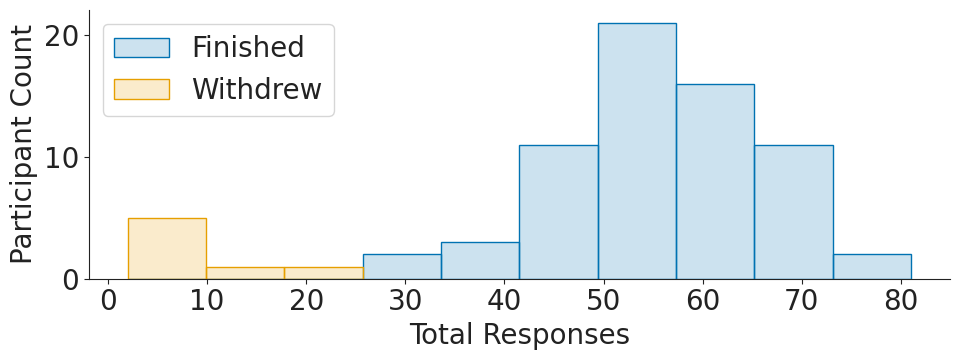

(27, 81)
(2, 21)


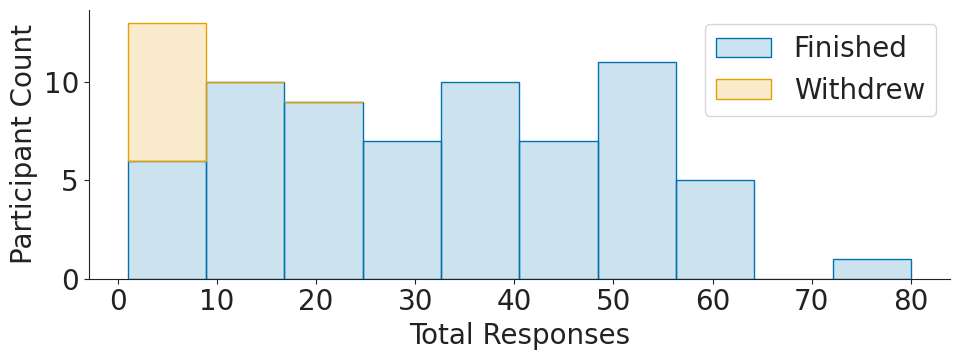

(4, 80)
(1, 6)


In [ ]:
def local(df,file):

    withdrew = [425, 438, 459, 462, 478, 484, 487]
    
    x1 = df[~df["ParticipantId"].isin(withdrew)].groupby("ParticipantId").size()
    x2 = df[df["ParticipantId"].isin(withdrew)].groupby("ParticipantId").size()

    plt.figure(figsize=(10,4))
    _,_,e = plt.hist([x1,x2], color=[c1+"33",c2+"33"], label=['Finished','Withdrew'], stacked=True, bins=10)

    for p in e[0].patches: p.set_edgecolor(c1) #type: ignore
    for p in e[1].patches[:3]: p.set_edgecolor(c2) #type: ignore

    ax = plt.gca()
    ax.set_ylabel("Participant Count")
    ax.set_xlabel("Total Responses")
    plt.legend()
    plt.tight_layout()

    plt.savefig(f'../figs/{file}',format='pdf', bbox_inches="tight")
    plt.show()

    print((x1.min(),x1.max()))
    print((x2.min(),x2.max()))
    
local(emotions_df[~emotions_df["SubmissionTimestampUtc"].isna()],"response_count_hist.pdf")
local(emotions_df[(~emotions_df["SubmissionTimestampUtc"].isna()) & (emotions_df["State Anxiety"] > 1)],"response_count_hist_sans1.pdf")

In [13]:
print(emotions_df[(~emotions_df["SubmissionTimestampUtc"].isna()) & (emotions_df["State Anxiety"]==1)]["Response Time (min)"].mean())
print(emotions_df[(~emotions_df["SubmissionTimestampUtc"].isna()) & (emotions_df["State Anxiety"]!=1)]["Response Time (min)"].mean())
print(9.18-7.76)

print(f"1 minute and {.42*60} seconds")

7.756571759246322
9.17881488067833
1.42
1 minute and 25.2 seconds


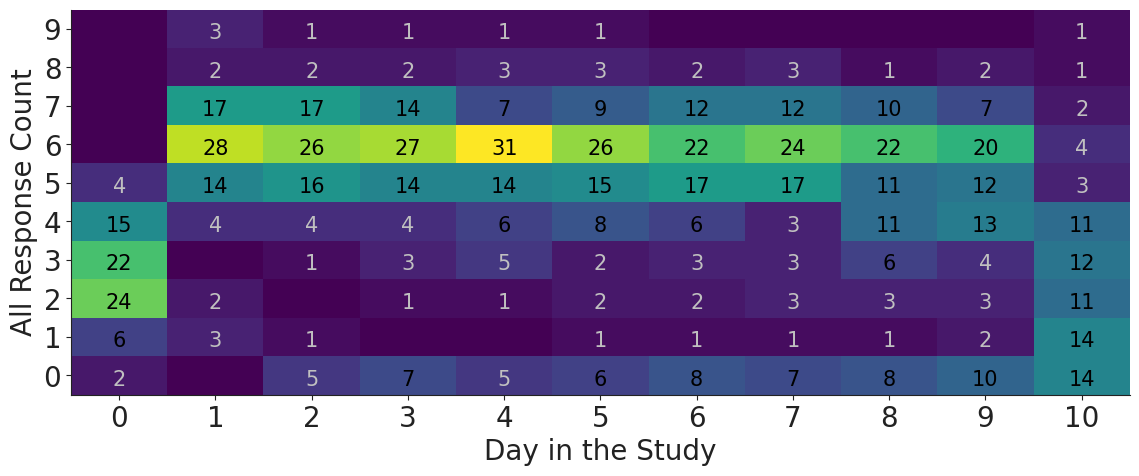

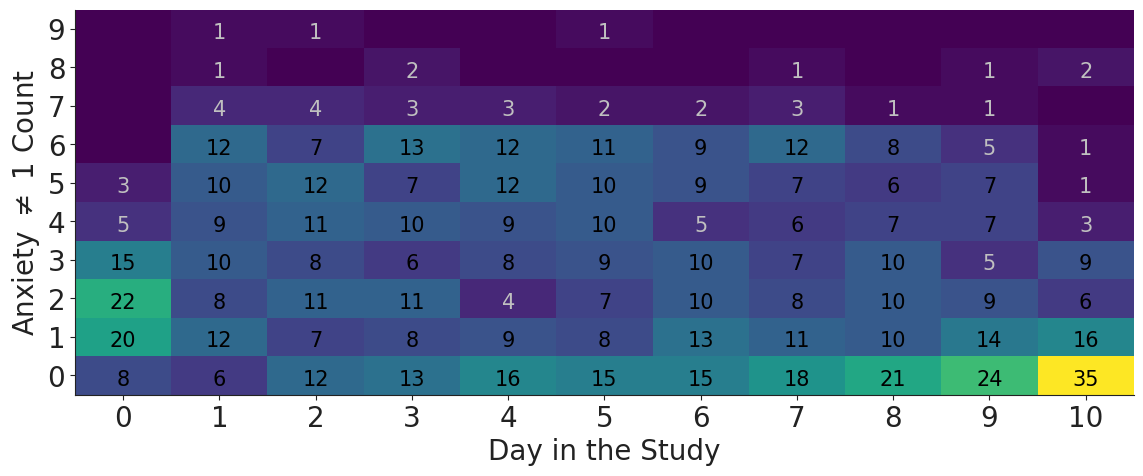

In [130]:
def local(df,ylabel,title=True,file=None):
    n_pid = len(set(emotions_df["ParticipantId"].tolist()))
    df = df.groupby(["ParticipantId","RelDay"]).size().reset_index().rename(columns={0:"Count"})
    counts2d = df.groupby(["RelDay","Count"]).size().to_dict()

    heatmap = np.empty((11,10))
    for x in range(11):
        for y in range(10):
            if y == 0:
                heatmap[x,y] = n_pid - sum(counts2d.get((x,_y),0) for _y in range(10)) 
            else:
                heatmap[x,y] = counts2d.get((x,y),0)
    
    plt.figure(figsize=(30,5))
    extent = (0, 11, 1, 11)
    if title: plt.title(f"{ylabel} By Day\n")
    plt.imshow(heatmap.T, extent=extent, origin='lower',aspect=.40)
    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            if heatmap[i,j]:
                plt.gca().text(.5+i, 1.4+j, str(int(heatmap[i, j])), ha="center", va="center", color="black" if heatmap[i, j] > 5 else "silver", fontdict={"size":15})
    plt.yticks([x+0.5 for x in range(1,11)],[str(x) for x in range(0,10)])
    plt.xticks([x+0.5 for x in range(0,11)],[str(x) for x in range(0,11)])
    plt.ylabel(ylabel)
    plt.xlabel("Day in the Study")
    if file: plt.savefig(f'../figs/{file}.pdf',format='pdf', bbox_inches="tight")
    plt.show()

    #print(df.groupby("RelDay")["Count"].median())
    #print(df[~df["RelDay"].isin([0,10])]["Count"].median())
    #print(df[df["RelDay"].isin([0,10])]["Count"].median())
    #return print(df.groupby("RelDay")["Count"].sum().to_dict())
local(emotions_df[~emotions_df["SubmissionTimestampUtc"].isna()],"All Response Count",title=False,file="response_day_heat")
#local(emotions_df[ emotions_df["SubmissionTimestampUtc"].isna()],"Participant Non-Response Count")
#local(emotions_df[(~emotions_df["SubmissionTimestampUtc"].isna() ) & (emotions_df["State Anxiety"] == 1)],"Participant Anxiety==1 Count")
local(emotions_df[(~emotions_df["SubmissionTimestampUtc"].isna() ) & (emotions_df["State Anxiety"] != 1)],"Anxiety $\\neq$ 1 Count",title=False,file="response_day_heat_sans1")

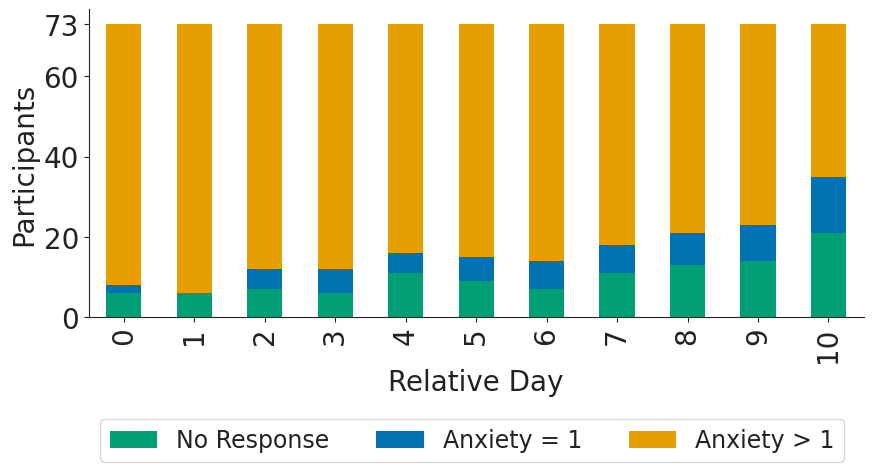

In [112]:
def local():

    p_anxiety_eq_1_count = emotions_df[(~emotions_df["SubmissionTimestampUtc"].isna()) & (emotions_df["State Anxiety"] == 1)].groupby(["RelDay","ParticipantId"]).size()
    p_anxiety_ge_1_count = emotions_df[(~emotions_df["SubmissionTimestampUtc"].isna()) & (emotions_df["State Anxiety"] >= 1)].groupby(["RelDay","ParticipantId"]).size()

    df = pd.concat([p_anxiety_eq_1_count,p_anxiety_ge_1_count],axis=1).fillna(0)
    participant_count = df.index.get_level_values("ParticipantId").unique().shape[0]

    eq_1_count = (df[0] == df[1]).groupby("RelDay").sum()
    ne_1_count = (df[0] != df[1]).groupby("RelDay").sum()
    none_count = participant_count-df[[1]].groupby("RelDay").size()

    df = pd.concat([eq_1_count,none_count,ne_1_count],axis=1)
    df = df.rename(columns={0:"No Response",1:"Anxiety = 1",2:"Anxiety > 1"})
    df.plot(kind="bar",stacked=True, figsize=(10,4),color=[c3,c1,c2])
    plt.gca().legend(loc='center left', bbox_to_anchor=(0, -.40),ncols=3,fontsize=17)
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10],["0","1","2","3","4","5","6","7","8","9","10"])
    plt.yticks([0,20,40,60,73])
    plt.xlabel("Relative Day")
    plt.ylabel("Participants")
    plt.savefig(f'../figs/response_day_type_count.pdf',format='pdf', bbox_inches="tight")
local()

### ~88% of delivered Current Emotions Surveys Were Responded To

In [18]:
def local():
    return round(100*(~emotions_df["SubmissionTimestampUtc"].isna()).sum()/emotions_df.shape[0],2)
local()

88.23

In [19]:
df = emotions_df[(~emotions_df["SubmissionTimestampUtc"].isna()) & (emotions_df["State Anxiety"]!=1)]
print(df.groupby("ParticipantId")["ER Interest"].mean().min())
print(df.groupby("ParticipantId")["ER Interest"].mean().max())
print(df.groupby("ParticipantId")["ER Interest"].mean().mean())
print(df.groupby("ParticipantId")["ER Interest"].mean().std())

1.0
9.571428571428571
3.1049893325922793
1.6717192163301915


73
70.0


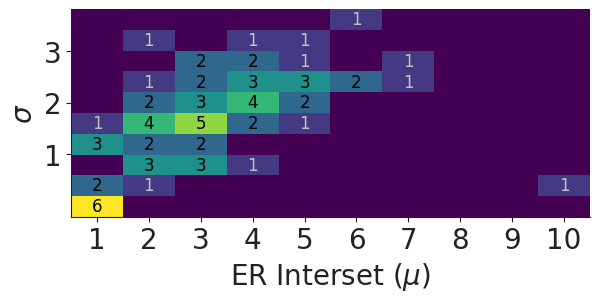

In [135]:
def local():

    df = emotions_df[(~emotions_df["ER Interest"].isna()) & (emotions_df["State Anxiety"]>1)]
    df = df.groupby(["ParticipantId"])["ER Interest"].agg(['std','mean']).reset_index(drop=False)

    print(len(df))

    xc,yc = "mean","std"
    nx,xl,xh = 10,1,11
    ny,yl,yh = 10,0,4

    xs = (xh-xl)/nx
    ys = (yh-yl)/ny

    x0s,x1s = zip(*[((x1-xl)/xs, x1) for x1 in [1,2,3,4,5,6,7,8,9,10]])
    y0s,y1s = zip(*[((y1-yl)/ys, y1) for y1 in [1,2,3]    ])

    heatmap = np.empty((nx,ny))
    for x in range(nx):
        for y in range(ny):
            in_x = (xl+x*xs-xs/2 <= df[xc]) & (df[xc] < xl+x*xs+xs/2)
            in_y = (yl+y*ys-ys/2 <= df[yc]) & (df[yc] < yl+y*ys+ys/2)
            heatmap[x,y] = len(df[in_x & in_y])

    print(heatmap.sum())

    plt.imshow(heatmap.T, origin='lower',aspect=.4)
    for x in range(nx):
        for y in range(ny):
            if heatmap[x, y]:
                plt.gca().text(x, y, str(int(heatmap[x, y])), ha="center", va="center", color="black" if heatmap[x, y] > 1 else "silver", fontdict={"size":12})
    plt.xticks(x0s,x1s)
    plt.yticks(y0s,y1s)
    plt.xlabel("ER Interset ($\\mu$)")
    plt.ylabel("$\\sigma$")

    plt.tight_layout()
    plt.savefig(f'../figs/interest_mean_sd_heat_sans1.pdf',format='pdf', bbox_inches="tight")
    plt.show()

local()

70
70.0


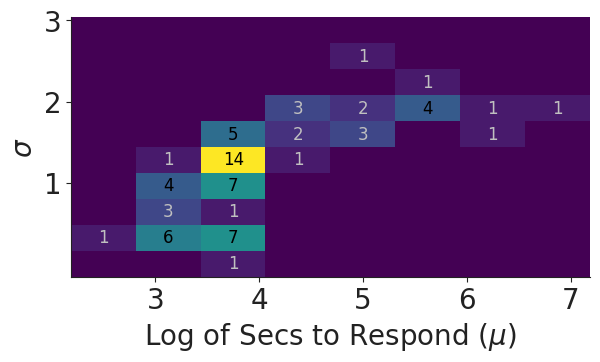

In [139]:
def local():

    df = emotions_df[(~emotions_df["ER Interest"].isna()) & (emotions_df["State Anxiety"]>1)]
    df = df.groupby(["ParticipantId"])["Response Time (log sec)"].agg(['std','mean','size']).reset_index(drop=False)
    df = df[(~df["mean"].isna())&(~df["std"].isna())] 

    print(len(df))

    xc,yc = "mean","std"
    nx,xl,xh = 8,2.5,7.5
    ny,yl,yh = 10,0,3.2
    
    xs = (xh-xl)/nx
    ys = (yh-yl)/ny

    x0s,x1s = zip(*[((x1-xl)/xs, x1) for x1 in [3,4,5,6,7]])
    y0s,y1s = zip(*[((y1-yl)/ys, y1) for y1 in [1,2,3]    ])

    heatmap = np.empty((nx,ny))
    for x in range(nx):
        for y in range(ny):
            in_x = (xl+x*xs-xs/2 <= df[xc]) & (df[xc] < xl+x*xs+xs/2)
            in_y = (yl+y*ys-ys/2 <= df[yc]) & (df[yc] < yl+y*ys+ys/2)
            heatmap[x,y] = len(df[in_x & in_y])

    print(heatmap.sum())

    plt.imshow(heatmap.T, origin='lower',aspect=.4)
    for x in range(nx):
        for y in range(ny):
            if heatmap[x, y]:
                plt.gca().text(x, y, str(int(heatmap[x, y])), ha="center", va="center", color="black" if heatmap[x, y] >= 4 else "silver", fontdict={"size":12})
    plt.xticks(x0s,x1s)
    plt.yticks(y0s,y1s)
    plt.xlabel("Log of Secs to Respond ($\\mu$)")
    plt.ylabel("$\\sigma$")
                 
    plt.tight_layout()
    plt.savefig(f'../figs/response_mean_sd_heat_sans1.pdf',format='pdf', bbox_inches="tight")
    plt.show()
    
local()

In [147]:
df = emotions_df[(~emotions_df["ER Interest"].isna()) & (emotions_df["State Anxiety"]>1)]
df = df.groupby(["ParticipantId"])["Response Time (log sec)"].agg(['std','mean','size']).reset_index(drop=False)
df = df[(~df["mean"].isna())&(~df["std"].isna())] 

(df["mean"] < np.log(60)).sum()

50

18.277219307140975

In [131]:
df = emotions_df[(~emotions_df["ER Interest"].isna()) & (emotions_df["State Anxiety"]>1)]
df = df.groupby(["ParticipantId"])["Response Time (log sec)"].agg(['std','mean','size']).reset_index(drop=False)
df = df[(~df["mean"].isna())&(~df["std"].isna())] 

In [134]:
df["mean"].std()

0.8731161456580465

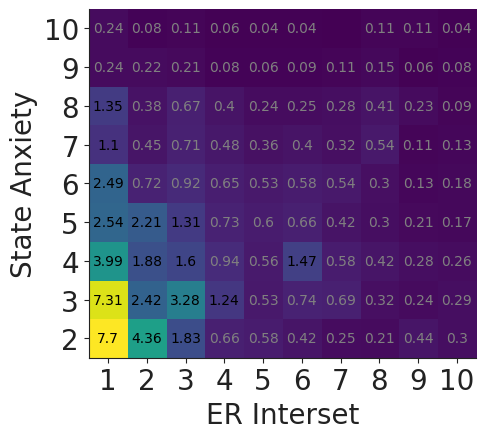

In [ ]:
def local():

    df = emotions_df[~emotions_df["ER Interest"].isna()]
    df = pd.merge(df,df.groupby("ParticipantId").size().reset_index())
    df[0] = 1/df[0]

    xc,yc = "ER Interest","State Anxiety"
    nx,xo,xs = 10,1,10/10
    ny,yo,ys = 9,2,9/9
    
    xticks = [(x-xo)/xs for x in range(1,11)]
    yticks = [(y-yo)/ys for y in range(2,11)]

    heatmap = np.empty((nx,ny))
    for x in range(nx):
        for y in range(ny):
            in_x = (xo+x*xs-xs/2 <= df[xc]) & (df[xc] < xo+x*xs+xs/2)
            in_y = (yo+y*ys-ys/2 <= df[yc]) & (df[yc] < yo+y*ys+ys/2)
            heatmap[x,y] = sum(df[in_x & in_y][0])

    plt.imshow(heatmap.T, origin='lower')
    for x in range(nx):
        for y in range(ny):
            if heatmap[x, y]:
                plt.gca().text(x, y, str(round(heatmap[x, y],2)), ha="center", va="center", color="black" if heatmap[x, y] >= 1 else "gray", fontdict={"size":10})
    plt.xticks(xticks,[str(int(xo+xs*x)) for x in xticks])
    plt.yticks(yticks,[str(int(yo+ys*y)) for y in yticks])
    plt.xlabel("ER Interset")
    plt.ylabel("State Anxiety")
    plt.tight_layout()
    plt.savefig(f'../figs/anxiet_interest_heat.pdf',format='pdf', bbox_inches="tight")
    plt.show()

local()

In [107]:
def idata(path, family, equation, minsamps=0, target_accept=.95, chains=16, tune=4000, draws=1000):
    if path: path = f"../bambi/{path}.json"
    if path and Path(path).exists(): return az.from_netcdf(path)

    df = emotions_df.copy()

    df = df[~df["SubmissionTimestampUtc"].isna()]
    df = df[~df["State Anxiety"].isna()]
    df = df[~df["ER Interest"].isna()]
    df = df[df["State Anxiety"] > 1]

    ng = df.groupby("ParticipantId").size().reset_index()
    df = pd.merge(df, ng[ng[0]>minsamps])

    df["RelDayn"] = df["RelDay"]
    df["RelDay"] = pd.Categorical(df["RelDay"].astype(int),ordered=True)
    df["State_Anxiety"] = pd.Categorical(df["State Anxiety"].astype(int),ordered=True)
    df["ER_Interest"] = pd.Categorical(df["ER Interest"].astype(int),ordered=True)
    df["Log_Response_Time"] = df["Response Time (log sec)"]

    md = bmb.Model(equation, df, family=family)
    mr = md.fit(draws=draws, tune=tune, chains=chains, target_accept=target_accept, cores=chains)

    md.predict(mr, kind="response", inplace=True)

    if path: az.to_netcdf(mr,path)

    return mr

def r2_score(idata, dependent):
    observed_data = idata.observed_data.get(dependent).to_dict().get("data") #type: ignore
    predicted_data = idata.posterior_predictive.stack(sample=("chain", "draw"))[dependent].values.T #type: ignore
    return az.r2_score(observed_data, predicted_data)

print("----------------------------")
print("--------- Interest ---------")
print("----------------------------")

mr = idata("interest_to_anxiety-reldayn-response", "cumulative", "ER_Interest ~ 1 + State_Anxiety + RelDayn + Log_Response_Time + (1 + State_Anxiety + RelDayn + Log_Response_Time | ParticipantId)", minsamps=0, chains=16, tune=2000, draws=1000, target_accept=.99)

print(r2_score(mr,"ER_Interest"))

display(az.summary(mr, var_names=["State_Anxiety", "RelDayn", "Log_Response_Time"],hdi_prob=.94))

print(mr.posterior["State_Anxiety|ParticipantId"].to_numpy().mean(axis=(0,1)).std(axis=1))

print("-----------------------")

print(mr.posterior["RelDayn|ParticipantId"].to_numpy().mean(axis=(0,1)).std())

print("-----------------------")

print(mr.posterior["Log_Response_Time|ParticipantId"].to_numpy().mean(axis=(0,1)).std())

print()
print("----------------------------")
print("--------- Response ---------")
print("----------------------------")

mr = idata("response_to_anxiety-reldayn-interest", "gaussian", "Log_Response_Time ~ 1 + State_Anxiety + RelDayn + ER_Interest + (1 + State_Anxiety + RelDayn + ER_Interest | ParticipantId)", minsamps=0, chains=16, tune=2000, draws=1000, target_accept=.99)

print(r2_score(mr,"Log_Response_Time"))

display(az.summary(mr, var_names=["State_Anxiety", "RelDayn", "ER_Interest"],hdi_prob=.94))

print(mr.posterior["State_Anxiety|ParticipantId"].to_numpy().mean(axis=(0,1)).std(axis=1))

print("-----------------------")

print(mr.posterior["RelDayn|ParticipantId"].to_numpy().mean(axis=(0,1)).std())

print("-----------------------")

print(mr.posterior["ER_Interest|ParticipantId"].to_numpy().mean(axis=(0,1)).std(axis=1))

----------------------------
--------- Interest ---------
----------------------------
r2        0.510085
r2_std    0.009301
dtype: float64


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
State_Anxiety[3],0.309,0.165,-0.002,0.619,0.002,0.001,8995.0,10074.0,1.00
State_Anxiety[4],0.930,0.172,0.600,1.249,0.002,0.001,8343.0,10504.0,1.00
State_Anxiety[5],0.881,0.186,0.545,1.246,0.002,0.001,8293.0,10827.0,1.00
State_Anxiety[6],1.303,0.183,0.962,1.650,0.002,0.001,8367.0,12251.0,1.00
State_Anxiety[7],1.433,0.206,1.049,1.821,0.002,0.002,8710.0,11696.0,1.00
State_Anxiety[8],1.342,0.310,0.741,1.911,0.004,0.003,7141.0,10484.0,1.00
State_Anxiety[9],1.170,0.416,0.388,1.950,0.004,0.003,9966.0,10865.0,1.00
State_Anxiety[10],1.840,0.846,0.212,3.411,0.011,0.008,5632.0,7946.0,1.00
RelDayn,-0.053,0.041,-0.130,0.025,0.001,0.001,3374.0,6462.0,1.01
Log_Response_Time,-0.048,0.033,-0.110,0.012,0.000,0.000,9396.0,8955.0,1.00


[0.20117042 0.19351869 0.1824387  0.0649549  0.07933942 0.57212809
 0.2953686  0.80001769]
-----------------------
0.22416580956538348
-----------------------
0.017104558652343768

----------------------------
--------- Response ---------
----------------------------
r2        0.438812
r2_std    0.009175
dtype: float64


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
State_Anxiety[3],0.148,0.104,-0.052,0.342,0.001,0.001,19057.0,14693.0,1.0
State_Anxiety[4],-0.053,0.112,-0.263,0.154,0.001,0.001,17212.0,14275.0,1.0
State_Anxiety[5],0.115,0.119,-0.115,0.337,0.001,0.001,17460.0,13964.0,1.0
State_Anxiety[6],0.175,0.134,-0.081,0.420,0.001,0.001,17533.0,13826.0,1.0
State_Anxiety[7],0.046,0.152,-0.234,0.335,0.001,0.001,17361.0,13847.0,1.0
State_Anxiety[8],-0.020,0.160,-0.303,0.296,0.001,0.001,20903.0,14504.0,1.0
State_Anxiety[9],-0.225,0.250,-0.678,0.257,0.002,0.002,21138.0,12825.0,1.0
State_Anxiety[10],-0.226,0.289,-0.780,0.307,0.002,0.002,25793.0,13328.0,1.0
RelDayn,-0.017,0.015,-0.045,0.011,0.000,0.000,18231.0,14048.0,1.0
ER_Interest[2],0.224,0.117,0.006,0.446,0.001,0.001,20935.0,14631.0,1.0


[0.02163794 0.01983197 0.02195982 0.0800101  0.08403442 0.0442474
 0.07841054 0.02013911]
-----------------------
0.04668976701387566
-----------------------
[0.08343535 0.07659074 0.05659594 0.0154236  0.03513397 0.10517713
 0.05376346 0.02503058 0.01961757]


In [ ]:
def idata(path, family, equation, minsamps=0, target_accept=.95, chains=16, tune=4000, draws=1000):
    if path: path = f"../bambi/{path}.json"
    if path and Path(path).exists(): return az.from_netcdf(path)

    df = emotions_df.copy()

    df = df[~df["SubmissionTimestampUtc"].isna()]
    df = df[~df["State Anxiety"].isna()]
    df = df[~df["ER Interest"].isna()]
    df = df[df["State Anxiety"] > 1]

    ng = df.groupby("ParticipantId").size().reset_index()
    df = pd.merge(df, ng[ng[0]>minsamps])

    df["RelDayn"] = df["RelDay"]
    df["RelDay"] = pd.Categorical(df["RelDay"].astype(int),ordered=True)
    df["State_Anxiety"] = pd.Categorical(df["State Anxiety"].astype(int),ordered=True)
    df["ER_Interest"] = pd.Categorical(df["ER Interest"].astype(int),ordered=True)
    df["Log_Response_Time"] = df["Response Time (log sec)"]
    df["ER_Interest_Z"] = df["ER Interest (Z)"]
    df["State_Anxiety_Z"] = df["State Anxiety (Z)"]

    md = bmb.Model(equation, df, family=family)
    mr = md.fit(draws=draws, tune=tune, chains=chains, target_accept=target_accept, cores=chains)

    md.predict(mr, kind="response", inplace=True)

    if path: az.to_netcdf(mr,path)

    return mr

def r2_score(idata, dependent):
    observed_data = idata.observed_data.get(dependent).to_dict().get("data") #type: ignore
    predicted_data = idata.posterior_predictive.stack(sample=("chain", "draw"))[dependent].values.T #type: ignore
    return az.r2_score(observed_data, predicted_data)

print("----------------------------")
print("--------- Interest ---------")
print("----------------------------")

mr = idata("interest_to_anxiety-reldayn-response", "cumulative", "ER_Interest ~ 1 + State_Anxiety + RelDayn + Log_Response_Time + (1 + State_Anxiety + RelDayn + Log_Response_Time | ParticipantId)", minsamps=0, chains=16, tune=2000, draws=1000, target_accept=.99)

print(r2_score(mr,"ER_Interest"))

display(az.summary(mr, var_names=["State_Anxiety", "RelDayn", "Log_Response_Time"],hdi_prob=.94))

print(mr.posterior["State_Anxiety|ParticipantId"].to_numpy().mean(axis=(0,1)).std(axis=1))

print("-----------------------")

print(mr.posterior["RelDayn|ParticipantId"].to_numpy().mean(axis=(0,1)).std())

print("-----------------------")

print(mr.posterior["Log_Response_Time|ParticipantId"].to_numpy().mean(axis=(0,1)).std())

print()
print("----------------------------")
print("--------- Response ---------")
print("----------------------------")

mr = idata("response_to_anxiety-reldayn-interest", "gaussian", "Log_Response_Time ~ 1 + State_Anxiety + RelDayn + ER_Interest + (1 + State_Anxiety + RelDayn + ER_Interest | ParticipantId)", minsamps=0, chains=16, tune=2000, draws=1000, target_accept=.99)

print(r2_score(mr,"Log_Response_Time"))

display(az.summary(mr, var_names=["State_Anxiety", "RelDayn", "ER_Interest"],hdi_prob=.94))

print(mr.posterior["State_Anxiety|ParticipantId"].to_numpy().mean(axis=(0,1)).std(axis=1))

print("-----------------------")

print(mr.posterior["RelDayn|ParticipantId"].to_numpy().mean(axis=(0,1)).std())

print("-----------------------")

print(mr.posterior["ER_Interest|ParticipantId"].to_numpy().mean(axis=(0,1)).std(axis=1))